In [10]:
import sys
all_paths = list(sys.path)
for p in all_paths:
    if "2.7" in p:
        sys.path.remove(p)
import uproot
import hist
import numpy as np
from hist.intervals import ratio_uncertainty
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")
from scipy.special import erf
from scipy.optimize import curve_fit
import re
from copy import deepcopy

In [11]:
def get_eff_hists(h, varname, ref_trig, probe_trig, **kwargs):
    rebin_factor = kwargs.pop("rebin_factor", 1.0)
    lookup_str = kwargs.pop("lookup_str", "")
    prescale_str = kwargs.pop("prescale_str", "")
    variation=kwargs.pop("variation", "nominal")
    common_hist_name = f"{varname}_{ref_trig}_{probe_trig}" + lookup_str
    h_ref = h[f"HLTEffHists/{common_hist_name}_denom"].to_hist()[hist.rebin(rebin_factor)]
    probe_hist_name = (
        f"{common_hist_name}{prescale_str}_num"
    )
    h_probe = h[f"HLTEffHists/{probe_hist_name}"].to_hist()[
        hist.rebin(rebin_factor)
    ]
    if variation != "nominal":
        direction = -1.0 if variation == "down" else 1.0
        h_ref = h_ref + direction*np.sqrt(h_ref.variances())
        h_probe = h_probe + direction*np.sqrt(h_probe.variances())
        
    sumw_num = h_probe.values()
    sumw_denom = h_ref.values()
    rsumw = np.nan_to_num(np.divide(sumw_num, sumw_denom, out=np.zeros_like(sumw_num), where=sumw_denom != 0))
    try:
        rsumw_err = np.nan_to_num(ratio_uncertainty(sumw_num, sumw_denom, "efficiency"))
    except ValueError as e:
        rsumw_err = 0.0
        print("denominator is larger than numerator.")
        print("Probably the denominator was filled with prescales as weight")
        print("setting errors to zero.")
        print(e)

    return h_ref, h_probe, rsumw, rsumw_err


In [15]:
def plot_scalefactor(year):
    h_data = uproot.open(f"/nfs/dust/cms/user/albrechs/UHH2/JetMassOutput/ttbarTrees/ForTriggerEff/Data_{year}.root")
    h_mc = uproot.open(f"/nfs/dust/cms/user/albrechs/UHH2/JetMassOutput/ttbarTrees/ForTriggerEff/QCD_{year}.root")
    f,ax = plt.subplots(figsize=(9, 9))
    colors = [
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    ]
    icolor = 0
    varname = "AK8_PT"
    xlabel="$p_{T,AK8}$"

    triggers = {
        "IsoMuonReference":[
            "AK8PFJet400",
            "AK8PFJet450",
            "AK8PFJet500",
            "AK8PFJet550",
            # "PFHT900",
            # "PFHT1050",
        ],
    }
    ref_trig = "IsoMuonReference"
    probe_trig="AK8PFJet500"
    prescale_str = ""
    lookup_str = "_lookup"
    rebin_factor=5

    def fit_func(z,a=0.5,b=0.5,c=400,d=0.1):
        # return a*erf((z-c)*d)+b
        #"[0]*([1]+0.5*(1-[1])*(1+TMath::Erfc((x-[2])/[3])))"
        return a*(b+0.5*(1-b)*(1+erf((z-c)/d)))
    def fit_erf(x_,y_, fit_range=(None, None)):
        x = deepcopy(x_)
        y=deepcopy(y_)
        p0 = (1., 0., 500.,40.)
        if fit_range[0] is not None:
            y=y[x>=fit_range[0]]
            x = x[x>=fit_range[0]]
        if fit_range[1] is not None:
            y=y[x<fit_range[1]]
            x = x[x<fit_range[1]]
        popt, pcov = curve_fit(fit_func, x, y, maxfev=8000, p0=p0)#, bounds=([0.99,0,300,0],[1,0.04,900,200]))
        
        return popt, pcov
    pt_thr_match = re.search( r"[0-9]{3}",probe_trig)
    pt_thr = 550 if not pt_thr_match else int(pt_thr_match.group())
    x_min=pt_thr-100
    x_max=pt_thr+150
    # x_min=0
    # x_max=1500
    variations=["nominal", "up", "down"]
    eff_data = {var:get_eff_hists(h_data, varname, ref_trig, probe_trig, rebin_factor=rebin_factor, lookup_str=lookup_str, prescale_str=prescale_str, variation=var) for var in variations}
    eff_mc = {var:get_eff_hists(h_mc, varname, ref_trig, probe_trig, rebin_factor=rebin_factor, lookup_str=lookup_str, prescale_str=prescale_str, variation=var) for var in variations}
    eff_fits = {k:{} for k in variations}
    sf_curves = {}
    fit_parameter={}
    x_plot = np.linspace(x_min,x_max,1000)
    for var in variations:
        alpha = 1.0 if var == "nominal" else 0.2
        # if var == "nominal":
        #     alpha=1.0
        ax.errorbar(eff_data[var][0].axes[0].centers,eff_data[var][2], yerr=eff_data[var][3], label=f"data ({var})",color="tab:red",linestyle="",marker=".", alpha=alpha)
        ax.errorbar(eff_mc[var][0].axes[0].centers,eff_mc[var][2], yerr=eff_mc[var][3], label=f"mc ({var})",color="tab:blue",linestyle="",marker="x", alpha=alpha)


        popt_data,_ = fit_erf(eff_data[var][0].axes[0].centers,eff_data[var][2], fit_range=(0,1000))
        popt_mc,_ = fit_erf(eff_mc[var][0].axes[0].centers,eff_mc[var][2], fit_range=(0,1000))
        fit_data = fit_func(x_plot, *popt_data)
        fit_mc = fit_func(x_plot, *popt_mc)

        eff_fits[var]["data"] = fit_data
        eff_fits[var]["mc"] = fit_mc
        sf_curves[var] = fit_data/fit_mc
        fit_parameter[var] = {"data":popt_data,"mc":popt_mc}
#     print(fit_parameter["nominal"]["data"])

#     control_plots=uproot.open(f"/nfs/dust/cms/user/albrechs/JetMassFits/flat_templates/control_plots/templates_{year}_1d_jecpt.root")
#     h_pt_jetht = control_plots["W_Data_pt"].to_hist()[hist.rebin(10)]
#     f1,ax1=plt.subplots()
#     h_pt_jetht_scaled = deepcopy(h_pt_jetht)*fit_func(h_pt_jetht.axes[0].centers,*fit_parameter["nominal"]["data"])
#     rsumw = h_pt_jetht_scaled.values()/h_pt_jetht.values()
#     rsumw_err = ratio_uncertainty(h_pt_jetht_scaled.values(),h_pt_jetht.values(),"efficiency")
#     ax1.errorbar(h_pt_jetht.axes[0].centers, rsumw, yerr=rsumw_err, color="k", alpha=0.5, label="JetHT pt folded effciency")
    
    ax.fill_between(x_plot, eff_fits["down"]["data"], eff_fits["up"]["data"], alpha=0.4, color="tab:red")
    ax.fill_between(x_plot, eff_fits["down"]["mc"], eff_fits["up"]["mc"], alpha=0.4, color="tab:blue")
    ax.plot(x_plot,eff_fits["nominal"]["data"], label=f"data fit",color="tab:red",alpha=0.9)
    ax.plot(x_plot,eff_fits["nominal"]["mc"],label=f"mc fit",color="tab:blue",alpha=0.9)
    
    ax.fill_between(x_plot[x_plot<500], sf_curves["down"][x_plot<500], sf_curves["up"][x_plot<500], alpha=0.1, color="k")
    ax.fill_between(x_plot[x_plot>=500], sf_curves["down"][x_plot>=500], sf_curves["up"][x_plot>=500], alpha=0.4, color="k")
    ax.plot(x_plot[x_plot<500], sf_curves["nominal"][x_plot<500], alpha=0.2, lw=2, ls="-.", color="k")
    ax.plot(x_plot[x_plot>=500], sf_curves["nominal"][x_plot>=500], label="Data/MC SF", alpha=0.9, lw=2, ls="-.", color="k")

    ax.axhline(1.0, color="black", linestyle="dashed", linewidth=1.0)
    ax.legend(ncols=1,fontsize=15)
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(0,1.2)


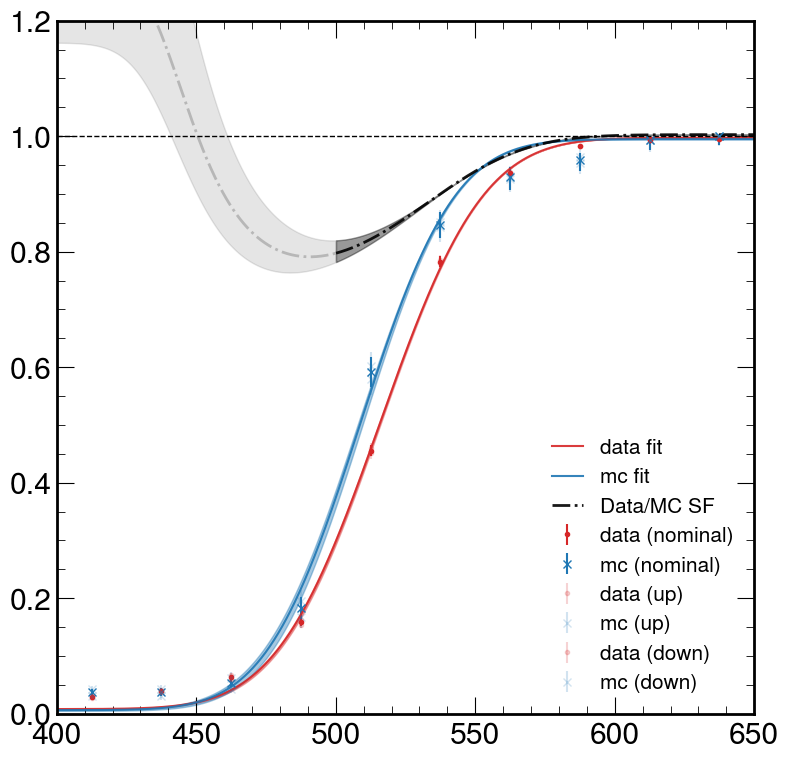

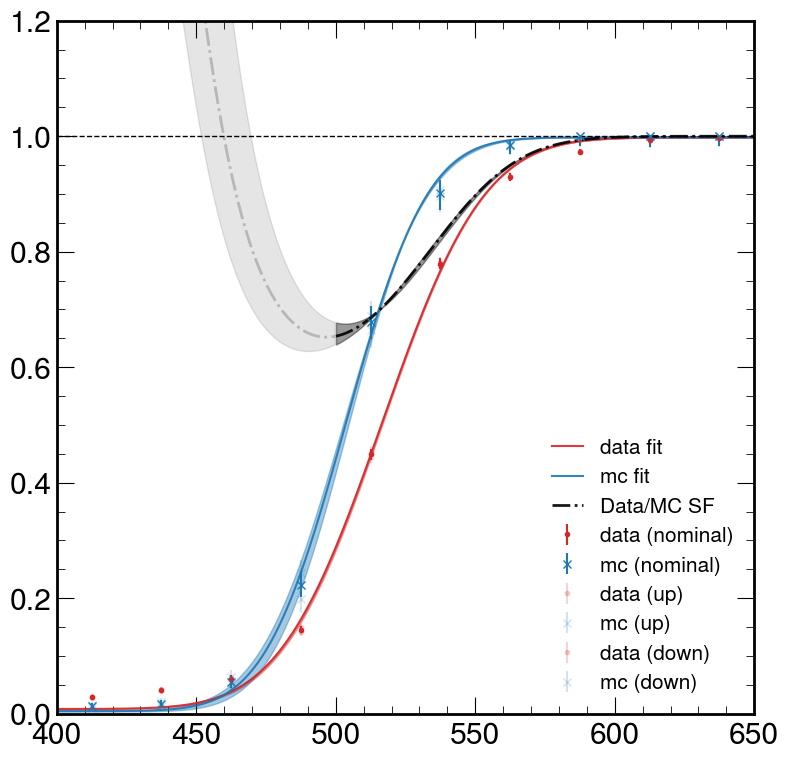

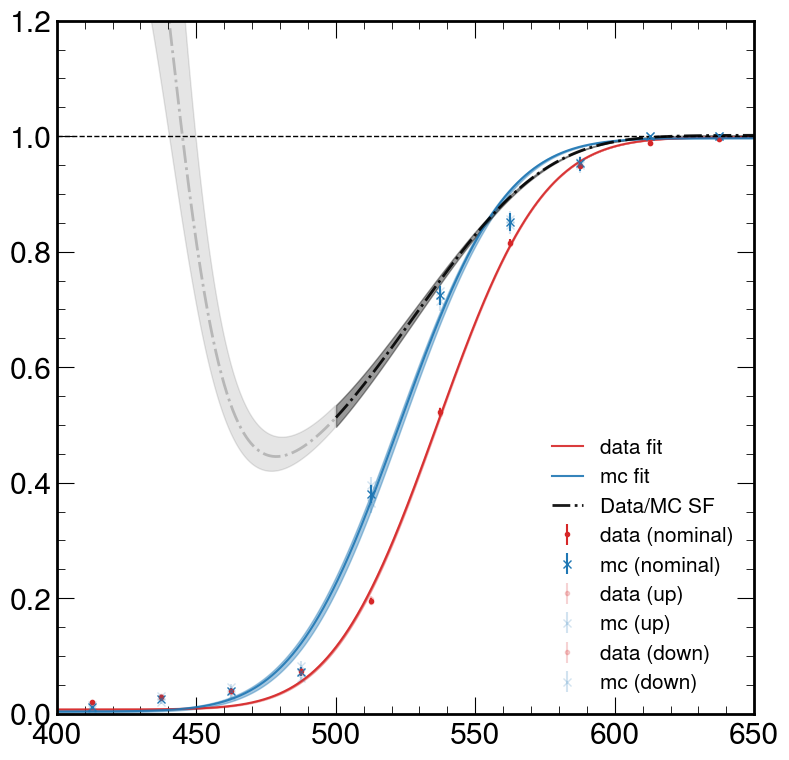

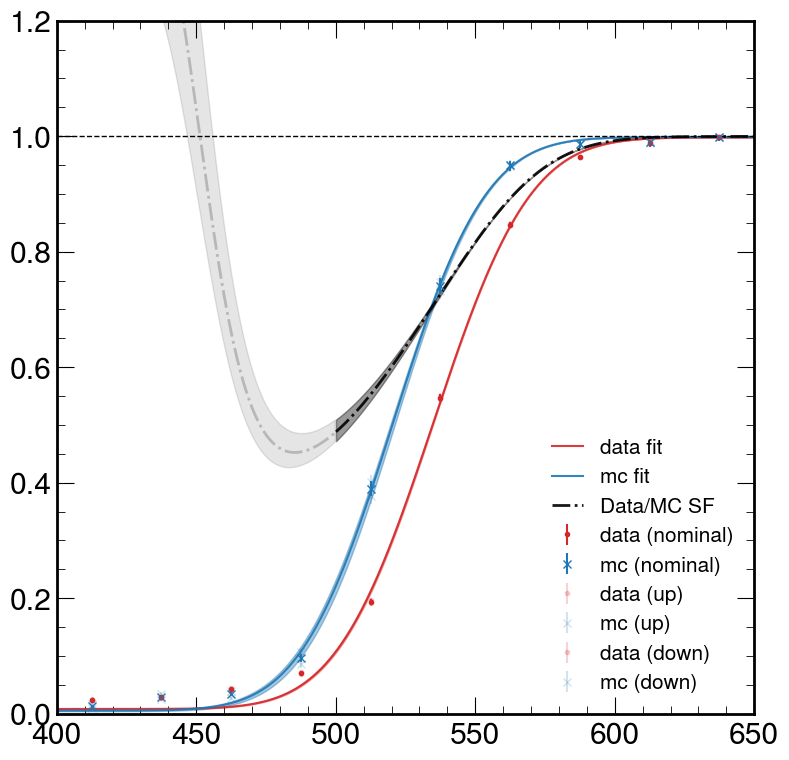

In [16]:

for year in ["UL16preVFP", "UL16postVFP", "UL17", "UL18"]:
    plot_scalefactor(year)